# Stage 2020-2021

# Active Learning appliqué à l'OPV (Photovoltaïques organiques) :

## 1- Importation des bibliothèques nécessaires :

### a) Bibliothèques usuelles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### b) Bibliothèques du Machine Learning

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

### c) Bibliothèques de l'Active Learning

In [3]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import uncertainty_sampling
from modAL.disagreement import max_std_sampling


## 2- Importation des données 

In [4]:
# loading dataset :
opv =  pd.read_csv("C:/Users/salma/OneDrive/Bureau/Stage 2020-2021/Machine Learning/Publications/OPV_publication/Data/table1_1.csv")
opv

,exp,don_con,total_con,spin_s,addive,pce,nb_dev
0,1,10,20,3000,2,0.05000,14
1,2,10,25,1000,8,3.24000,10
2,3,10,10,600,0,0.01600,14
3,4,10,15,2000,12,0.00040,10
4,5,25,20,600,12,7.14000,8
5,6,25,15,1000,2,3.22000,8
6,7,25,10,3000,8,0.00033,14
7,8,25,25,2000,0,7.21000,11
8,9,40,10,1000,12,1.85000,3
9,10,40,20,2000,8,6.16000,12


**a)** On sépare les facteurs et la variable cible.

In [5]:
X = opv[['don_con','total_con','spin_s']]
Y = opv['pce']

In [6]:
X_raw=X.to_numpy()
Y_raw=Y.to_numpy()

In [7]:
racine = 0
n_initial = X_raw.shape[0] 
size = 3
random.seed(racine)
lab_indices1 =  random.sample(range(n_initial), size)
print(lab_indices1)

[13, 6, 12]


In [8]:
# Les données étiquetées.
X_lab = X_raw[lab_indices1]
Y_lab = Y_raw[lab_indices1] 

In [9]:
Y_lab

array([3.18e+00, 3.30e-04, 1.16e+00])

In [10]:
# Les données non-étiquetées.
X_unlab = np.delete(X_raw, lab_indices1, axis=0) 
Y_unlab = np.delete(Y_raw, lab_indices1, axis=0)

# Active Learning :

In [11]:
def strat_max(pred, X_unlab, Y_unlab) :
    m = max(pred)
    query_index = np.argmax(pred)
    query_instance = X_unlab[query_index]
    label_index = Y_unlab[query_index]
    return query_index, query_instance, m

In [16]:
model = RandomForestRegressor(random_state=0)
model.fit(X_lab,Y_lab)
pred = model.predict(X_unlab)
query_index_init, query_instance_init, label_index_init = strat_max(pred, X_unlab, Y_unlab)

In [17]:
pred

array([1.2175848, 2.0502858, 1.2935287, 1.3915353, 2.0502858, 2.0502858,
       1.3915353, 1.2935287, 1.3915353, 2.0502858, 1.2175848, 2.336833 ])

In [18]:
print(label_index_init)

2.336833000000002


In [19]:
n_queries = 10
performance = []
y_pred_max = [label_index_init]
for index in range(n_queries):
    model = RandomForestRegressor(random_state=0)
    model.fit(X_lab,Y_lab)
    query_index, query_instance, label_i = strat_max(pred, X_unlab, Y_unlab)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    y_pred_max.append(label_i)
    X_lab, Y_lab= np.vstack([X_lab, query_instance]), np.hstack([Y_lab, label_i])    
    X_unlab, Y_unlab = np.delete(X_unlab, query_index, axis=0), np.delete(Y_unlab, query_index)
    # Remove the queried instance from the unlabeled pool.
    #print(predictions)
    pred = model.predict(X_unlab)
    print(pred)
    score = model.score(X,Y)
    performance.append(score)
    lab_indices1.append(query_index)

11
[1.2175848 2.0502858 1.2935287 1.3915353 2.0502858 2.0502858 1.3915353
 1.2935287 1.3915353 2.0502858 1.2175848]
1
[1.34725852 1.53506214 1.49221727 2.26302435 2.07927755 1.59164737
 1.4338821  1.59164737 2.26302435 1.15295321]
3
[1.32687826 1.77823507 1.52924445 2.00239781 1.62474544 1.50881164
 1.67067743 2.42536734 1.09722448]
7
[1.30250764 1.87959934 1.71655523 2.39286668 1.66259985 1.79912883
 1.69059314 1.25154939]
3
[1.39754881 1.67760241 1.73964649 1.77651237 1.6257755  1.80577881
 1.35783483]
5
[1.30387558 1.63405289 1.82705313 1.80461523 1.59839185 1.45072791]
2
[1.4705639  1.40918813 1.86855175 1.37949861 1.50598633]
2
[1.48756905 1.33589456 1.2849068  1.57507626]
3
[1.36507131 1.3858348  1.3409093 ]
1
[1.63360038 0.92595223]


Text(0, 0.5, 'PCE prédit')

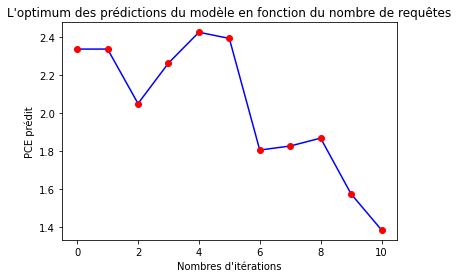

In [20]:
plt.title("L'optimum des prédictions du modèle en fonction du nombre d'itérations")
plt.plot(np.arange(n_queries+1), y_pred_max, 'b')
plt.plot(np.arange(n_queries+1), y_pred_max, 'ro')
plt.xlabel("Nombres d'itérations")
plt.ylabel("PCE prédit")

Text(0, 0.5, 'La performance du modèle')

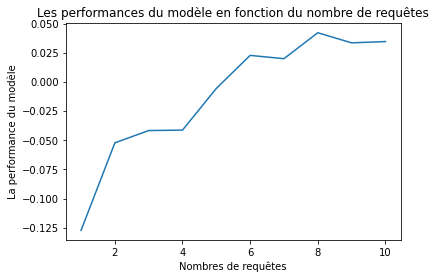

In [21]:
plt.title("Les performances du modèle en fonction du nombre de requêtes")
plt.plot(np.arange(1,n_queries+1), performance)
plt.xlabel("Nombres de requêtes")
plt.ylabel("La performance du modèle")

In [ ]:
n_queries = 10
performance = []
for index in range(n_queries):
    model = RandomForestRegressor(random_state=0)
    model.fit(X_lab,Y_lab)
    pred = model.predict(X_unlab)
    print(pred)
    score = model.score(X,Y)
    performance.append(score)
    query_index, query_instance, label_i = strat_max(pred, X_unlab, Y_unlab)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    X_new, Y_new = X_unlab[query_index].reshape(1, -1), Y_unlab[query_index].reshape(1, )
    X_lab, Y_lab= np.vstack([X_lab, query_instance]), np.hstack([Y_lab, label_i])    
    X_unlab, Y_unlab = np.delete(X_unlab, query_index, axis=0), np.delete(Y_unlab, query_index)
    # Remove the queried instance from the unlabeled pool.
    #print(predictions)
    lab_indices1.append(query_index)
    plt.figure(figsize=(15, 15))
    plt.subplot(5,2,index+1)
    for label, data in opv.groupby('exp'): 
        p1, = plt.plot(n_queries[index], max(pred), 'ko')
        #plt.plot(Y_unlab[query_index], )
        #p2, = plt.plot(Y_lab, pred[lab_indices1], 'ro')
        #p3, = plt.plot(Y[query_index], pred[query_index], 'go')
        plt.title('iteration no %d' % (index+1))
    plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
    plt.autoscale(enable = False)                    
    plt.legend([p1,p2,p3],["le jeu de données","données d'entraînement","données rajoutées"], loc='upper left')
    #plt.legend(loc='upper left', frameon = True)
    plt.xlim(0,10)                             
    plt.ylim(0,10)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    font = {'size': 15} 
    plt.xlabel(r'Measured pce', font)
    plt.ylabel(r'Predicted pce', font)